In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchvision
import torch
import torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import re
import nltk
nltk.download('stopwords')
import time
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.utils import shuffle


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/257_Project/train.csv', encoding="ISO-8859-1", header=None)
train_df.columns = ['polarity', 'id', 'date', 'query', 'user', 'tweet']

test_df = pd.read_csv('/content/drive/MyDrive/257_Project/test.csv', encoding="ISO-8859-1", header=None)
test_df.columns = ['polarity', 'id', 'date', 'query', 'user', 'tweet']

In [6]:
train_df.shape

(1600000, 6)

In [7]:
test_df.shape

(498, 6)

In [8]:
word_bank = []

# Function to remove predefined stopwords to reduce disk usage
def preprocess(text):
    review = re.sub('[^a-zA-Z]',' ',text) 
    review = review.lower()
    review = review.split()
    ps = LancasterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    return ' '.join(review)

Training the model on 50K samples for now, to check if the model runs properly and how the classfication works.


In [9]:
train_df = shuffle(train_df,random_state=2)
train_df = train_df[1:1000]

In [10]:
train_df['polarity'].value_counts()

0    523
4    476
Name: polarity, dtype: int64

In [11]:
X_train = train_df['tweet'].apply(lambda x: preprocess(x))

In [12]:
y_train = train_df['polarity']
le = LabelEncoder()
y = le.fit_transform(y_train)

In [13]:
X_test = test_df['tweet']
y_test = test_df['polarity']

In [14]:
tfidf = TfidfVectorizer(max_features = 100)
X_train_tf = tfidf.fit_transform(X_train).toarray() 
X_test = tfidf.transform(X_test).toarray()

In [15]:
X_train_tf.shape, X_test.shape, y_train.shape, y_test.shape

((999, 100), (498, 100), (999,), (498,))

**Logistic Regression**

In [16]:
lr = LogisticRegression(random_state = 0)
start_time = time.time()
lr.fit(X_train_tf, y_train) 
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.05013418197631836 secs


In [17]:
y_pred_lr = lr.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_lr))

Accuracy:
 0.44779116465863456


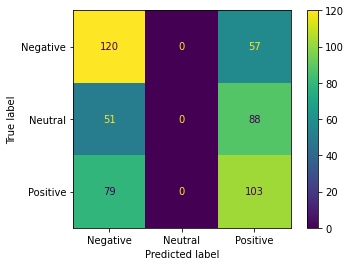

In [18]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Neutral','Positive'])
cm_display.plot()

Current accuracy of the model using logistic regression on 400k samples : ~42%



**Decision Tree**

In [19]:
dc = DecisionTreeClassifier(criterion = 'entropy', random_state = 22)
start_time = time.time()
dc.fit(X_train_tf, y_train)
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.1045985221862793 secs


In [20]:
y_pred_dc = dc.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_dc))

Accuracy:
 0.41365461847389556


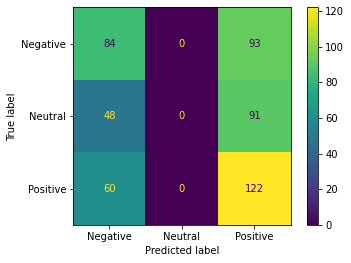

In [21]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Neutral' ,'Positive'])
cm_display.plot()

Current accuracy of the model using decision tree classifier on 50k samples : ~41%

**Naive Bayes Classifier**

In [22]:
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train_tf,y_train)
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.0028944015502929688 secs


In [23]:
y_pred_nb = nb.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_nb))

Accuracy:
 0.4397590361445783


Current accuracy of the model using decision tree classifier on 400k samples : ~42%

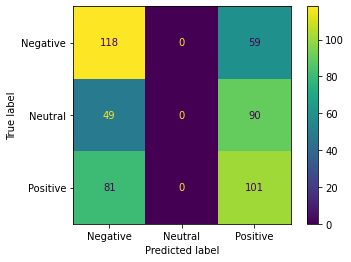

In [24]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_nb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Neutral', 'Positive'])
cm_display.plot()

Since the model accuracy was very low. I filtered out the neutral tweet label and made it positive. Neutral label tag was removed altogether.

In [25]:
train_df['polarity'] = train_df['polarity'].replace(4,1)
train_df

,polarity,id,date,query,user,tweet
408251,0,2059364084,Sat Jun 06 16:47:03 PDT 2009,NO_QUERY,MrsAmarieB,my baby's growing up
1559739,1,2186151891,Mon Jun 15 18:25:49 PDT 2009,NO_QUERY,epallaviccini,Painted Black-Rolling Stones..the best!
571248,0,2208723981,Wed Jun 17 09:33:02 PDT 2009,NO_QUERY,Kiwitabby,"kk, i'm logging off now BYEZZ!"
524639,0,2193564503,Tue Jun 16 08:37:46 PDT 2009,NO_QUERY,annaqui,Shitty shitty shitty news today
311150,0,2001240587,Tue Jun 02 00:15:30 PDT 2009,NO_QUERY,smellyocheese,@Askmewhats * hugs* what's wrong?
...,...,...,...,...,...,...
654734,0,2239581310,Fri Jun 19 08:43:05 PDT 2009,NO_QUERY,RememberBataan,obviously not going to have time for the gym t...
751053,0,2285902061,Mon Jun 22 15:44:05 PDT 2009,NO_QUERY,deepoffenberger,waiting to hear from the vet about hymie
772903,0,2302962179,Tue Jun 23 17:32:15 PDT 2009,NO_QUERY,Bridgett26,so disappointed about dinner...bad veggie lo m...
1535977,1,2179155023,Mon Jun 15 08:43:15 PDT 2009,NO_QUERY,role_model,@simpleplan i'm going! see you guys in 4 days...


In [26]:
test_df

,polarity,id,date,query,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,2,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [27]:
test_df['polarity'] = test_df['polarity'].replace(2,1)
test_df

,polarity,id,date,query,user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,1,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,4,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [28]:
test_df['polarity'] = test_df['polarity'].replace(4,1)
test_df

,polarity,id,date,query,user,tweet
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
...,...,...,...,...,...,...
493,1,14072,Sun Jun 14 04:31:43 UTC 2009,latex,proggit,Ask Programming: LaTeX or InDesign?: submitted...
494,0,14073,Sun Jun 14 04:32:17 UTC 2009,latex,sam33r,"On that note, I hate Word. I hate Pages. I hat..."
495,1,14074,Sun Jun 14 04:36:34 UTC 2009,latex,iamtheonlyjosie,Ahhh... back in a *real* text editing environm...
496,0,14075,Sun Jun 14 21:36:07 UTC 2009,iran,plutopup7,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


In [29]:
X_train = train_df['tweet'].apply(lambda x: preprocess(x))

In [30]:
y_train = train_df['polarity']
le = LabelEncoder()
y = le.fit_transform(y_train)

In [31]:
X_test = test_df['tweet']
y_test = test_df['polarity']

In [32]:
X_train_tf.shape, X_test.shape, y_train.shape, y_test.shape

((999, 100), (498,), (999,), (498,))

In [41]:
tfidf = TfidfVectorizer(max_features = 100)
X_train_tf = tfidf.fit_transform(X_train).toarray() 
X_test = tfidf.transform(X_test).toarray()

**Logistic Regreession**

In [42]:
lrr = LogisticRegression(random_state = 0)
start_time = time.time()
lrr.fit(X_train_tf, y_train) 
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.03624677658081055 secs


In [43]:
y_pred_lrr = lrr.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_lrr))


Accuracy:
 0.6244979919678715


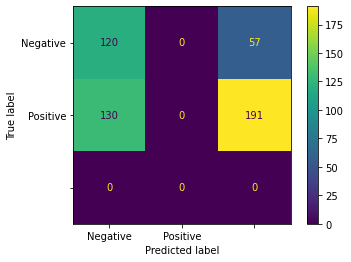

In [44]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_lr)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()

Current accuracy of the model using logistic regression on 400k samples : ~74%

**Decision Tree Classifier**

In [45]:
dc = DecisionTreeClassifier(criterion = 'entropy', random_state = 22)
start_time = time.time()
dc.fit(X_train_tf, y_train)
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.04374837875366211 secs


In [46]:
y_pred_dc = dc.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_dc))

Accuracy:
 0.5963855421686747


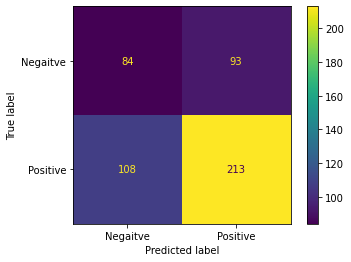

In [47]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_dc)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negaitve','Positive'])
cm_display.plot()

Current accuracy of the model using decision tree classifier on 400k samples : ~65%

**Naive Bayes Classifier**

In [48]:
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train_tf,y_train)
print("Execution Time:", time.time()-start_time,"secs")

Execution Time: 0.004961729049682617 secs


In [49]:
y_pred_nb = nb.predict(X_test)
print("Accuracy:\n", accuracy_score(y_test, y_pred_nb))


Accuracy:
 0.6204819277108434


Current accuracy of the model using decision tree classifier on 400k samples : ~72%

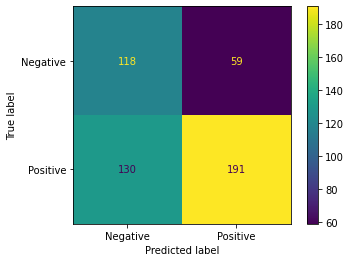

In [50]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_nb)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative','Positive'])
cm_display.plot()